## Interpretabilidade e Conclusões

Objetivo:
- Interpretar o modelo final (XGBoost)
- Analisar importância global e local de variáveis (SHAP)
- Gerar gráficos e explicações para o relatório e vídeo

### Importação de bibliotecas e dados

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import shap

O ***SHAP (SHapley Additive exPlanations)*** é um método inspirado na teoria dos jogos:
ele atribui a cada feature um “peso de contribuição” para a previsão final do modelo — permitindo interpretar até modelos complexos como o XGBoost.

### Preparar os dados e modelo

In [2]:
# Carrega novamente o dataset
data = load_breast_cancer(as_frame=True)
df = data.frame
df['target'] = data.target

X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Treina o modelo final (com parâmetros otimizados do notebook anterior)
model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

Aqui usamos o modelo final que teve melhor desempenho na fase anterior (***XGBoost***).
Ele já representa o ponto mais alto da nossa pipeline.

### Importancia global (Feature Importance)

/var/folders/23/23v9dnyx4cqcz4cp1d658w7c0000gn/T/ipykernel_22057/560094773.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette='magma')


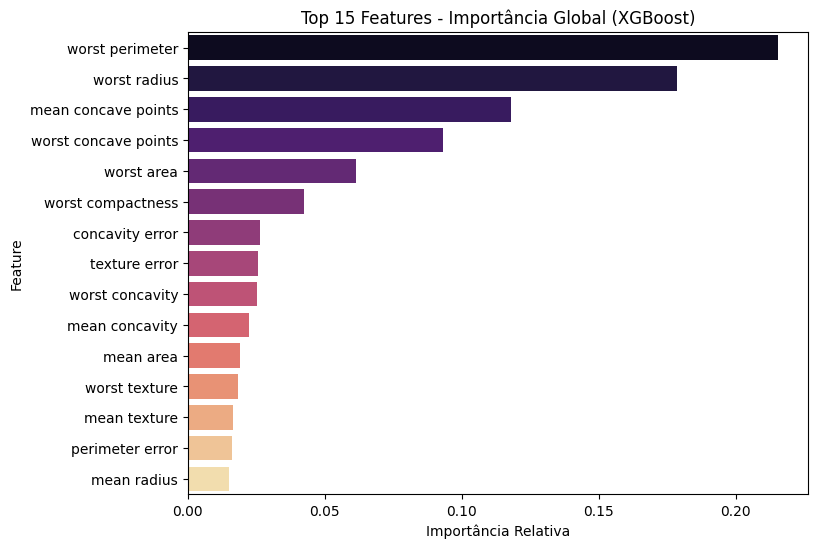

In [3]:
importances = pd.Series(model.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(8,6))
sns.barplot(x=top_features.values, y=top_features.index, palette='magma')
plt.title('Top 15 Features - Importância Global (XGBoost)')
plt.xlabel('Importância Relativa')
plt.ylabel('Feature')
plt.show()


Esse gráfico mostra a **importância global** média de cada feature.

As variáveis mais altas são as que o modelo mais utiliza para dividir as classes.

No contexto médico, serve como ponto de partida para discutir ***quais medidas celulares*** são mais relevantes para o diagnóstico.

### Interepretabilidade local e global com SHAP

In [4]:
# Inicializa o interpretador SHAP
explainer = shap.Explainer(model, X_train, feature_names=X.columns)
shap_values = explainer(X_test)

O SHAP cria uma decomposição da predição para cada observação.

Cada valor de SHAP indica **quanto uma feature aumentou ou diminuiu a probabilidade de um tumor ser maligno**.

### Gráfico de resumo (SHAP Summary Plot)

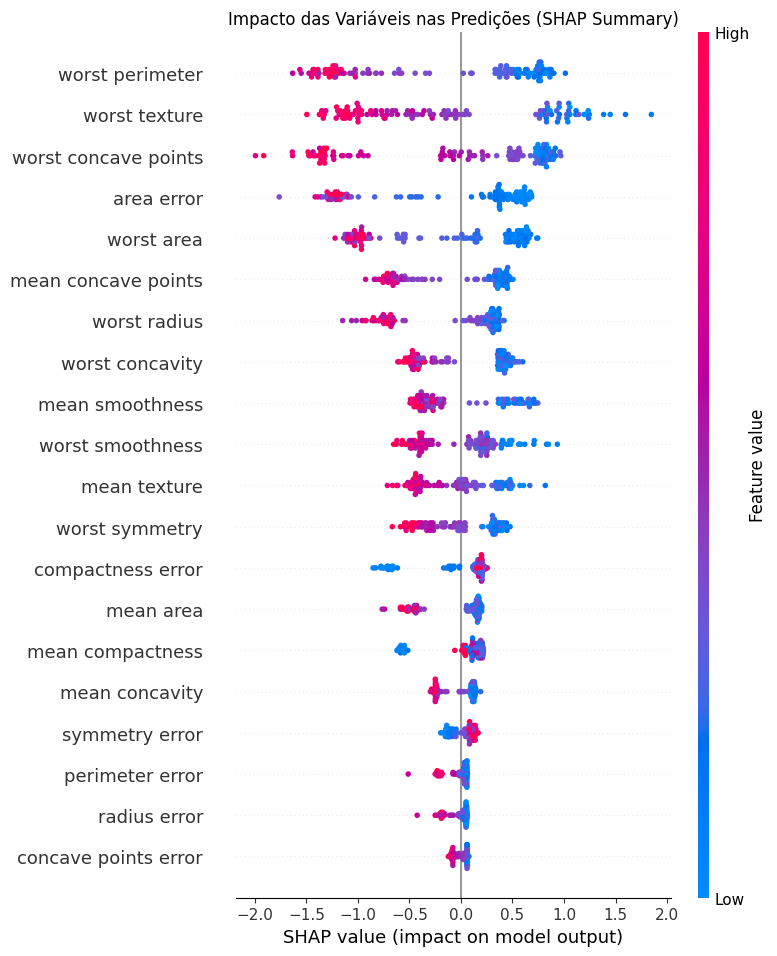

In [5]:
shap.summary_plot(shap_values, X_test, plot_type="dot", show=False)
plt.title("Impacto das Variáveis nas Predições (SHAP Summary)")
plt.show()


Cada ponto representa uma amostra.


A cor mostra o valor da feature (vermelho = alto, azul = baixo).

Se o ponto está à direita, significa que aquele valor aumenta a chance de ser maligno; à esquerda, reduz.

Esse gráfico é fundamental pois traduz a “intuição” do modelo.

### Análise local (SHAP Force Plot)

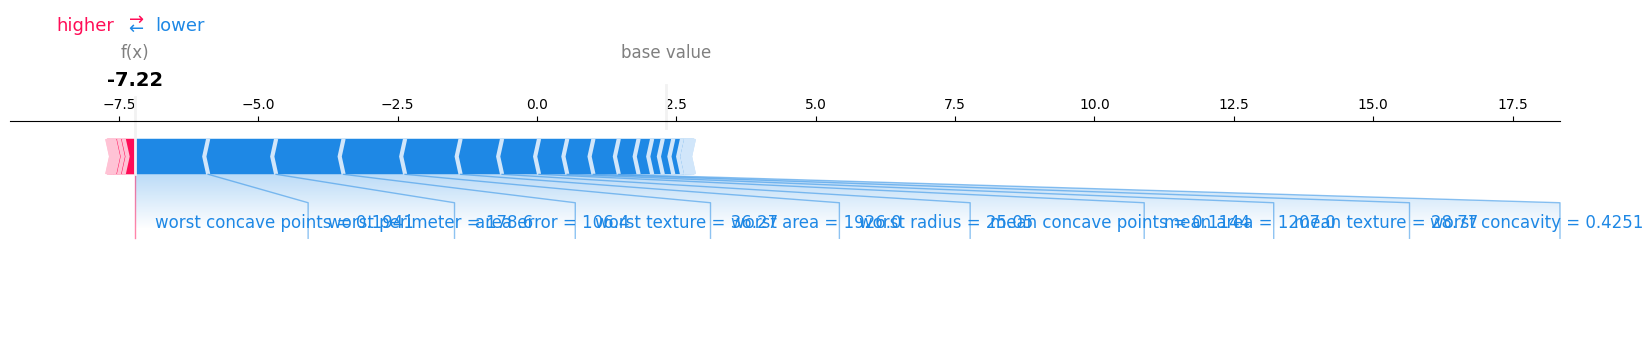

In [6]:
# Escolhe uma observação individual (por exemplo, o primeiro caso de teste)
idx = 0
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[idx].values, X_test.iloc[idx], matplotlib=True)


O Force Plot explica uma previsão individual:

- as variáveis em vermelho empurram a previsão para “maligno”,

- as em azul empurram para “benigno”.

É um excelente recurso pois pode mostrar que o modelo não é uma “caixa-preta”, mas uma decisão ponderada.

### SHAP bar chart (importância média absoluta)

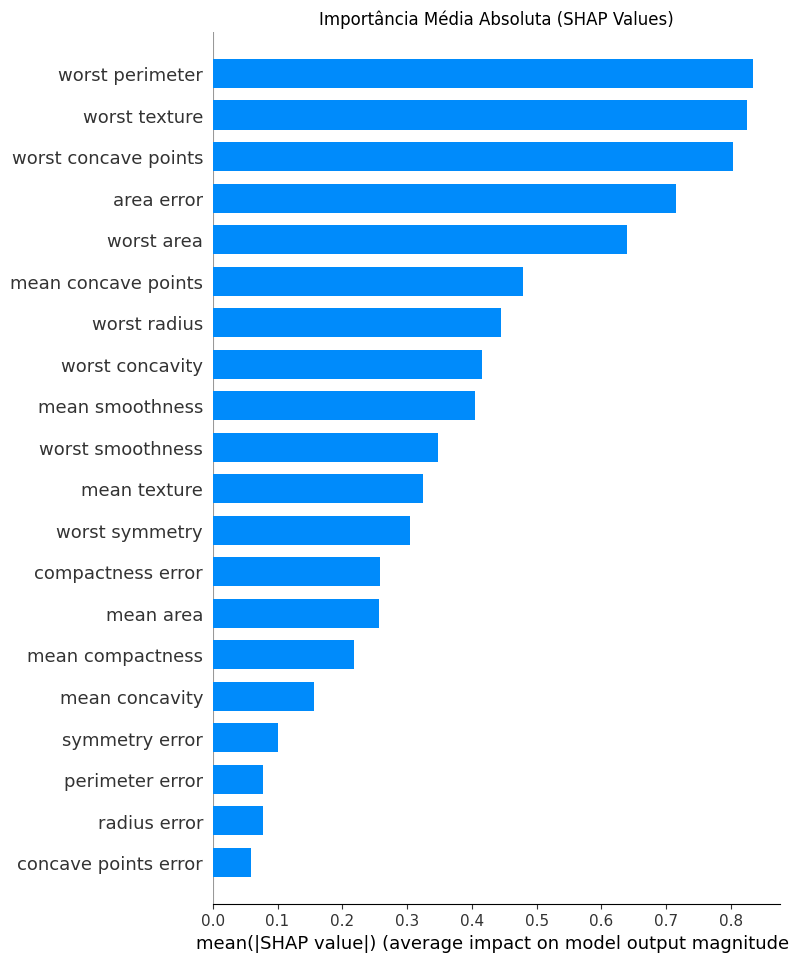

In [7]:
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("Importância Média Absoluta (SHAP Values)")
plt.show()


Aqui vemos a magnitude média das contribuições, ou seja, o impacto absoluto de cada variável na decisão do modelo.

Serve para confirmar a consistência com a feature importance do ***XGBoost***.

### Interpretação e implicações clínicas

A análise com SHAP confirmou que as variáveis **worst concave points**, **mean concave points**, **worst area** e **mean radius**
são as mais influentes para determinar se um tumor é maligno.  
Essas características estão ligadas à **irregularidade e tamanho das células**, fatores historicamente associados ao câncer de mama.  

O modelo mostrou um padrão consistente e biologicamente plausível, reforçando a confiança na sua aplicação como ferramenta de suporte, 
não substituindo o diagnóstico médico, mas auxiliando na triagem e priorização de casos suspeitos.


## Conclusao Final da Fase 1

Nesta última etapa, o modelo foi interpretado sob duas perspectivas:

1. **Global** – identificando quais variáveis mais influenciam o diagnóstico geral.  
2. **Local** – explicando individualmente por que o modelo classificou cada paciente como maligno ou benigno.  

Os resultados mostraram coerência entre o comportamento estatístico e o conhecimento médico.  
O SHAP proporcionou transparência e interpretabilidade, aspectos essenciais para o uso ético de IA na saúde.  

**Conclusão geral da Fase 1:**  
- O modelo XGBoost apresentou desempenho superior, com alto recall e AUC.  
- As variáveis relacionadas à forma e concavidade celular são as mais relevantes.  
- O sistema é robusto, interpretável e pronto para a próxima fase —  integração com interface interativa ou API de inferência.
